In [1]:
from src.data_loader import load_building_info, load_and_merge
from src.features import add_time_features, drop_unused_features

building_encoded = load_building_info()

train_df = load_and_merge(building_info=building_encoded)
# 이상치 제거: 전력 소비량 0 제외
train_df = train_df[train_df['전력소비량(kWh)'] != 0]
train_df = add_time_features(train_df)
train_df = drop_unused_features(train_df)

In [2]:
# 전처리
from src.features import (
    fit_weather_pca, transform_weather_pca,
    split_features_target,
    scale_features, train_valid_split
)

scaler_w, pca_w = fit_weather_pca(train_df)
train_df = transform_weather_pca(train_df, scaler_w, pca_w)

X, y = split_features_target(train_df)
X_scaled, scaler = scale_features(X)
X_train, X_valid, y_train, y_valid = train_valid_split(X_scaled, y)

print(X_train.shape,X_valid.shape)  ## 열의 갯수가 같아야한다.
                                    ## y의 열 갯수는 1이여야함.
print(y_train.shape,y_valid.shape)  ## train , test 끼리는 행의 갯수가 같아야한다.

(163145, 20) (40787, 20)
(163145,) (40787,)


#### 모델링: 다중선형회귀, RF, XGB, LightGBM

In [3]:
from src.models import train_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

model_lr = train_model(LinearRegression, X_train, y_train)
model_rf = train_model(RandomForestRegressor, X_train, y_train, random_state=42, n_estimators=250)

# 시각화: RandomForest 특성 중요도

In [4]:
# # 한글폰트 설정
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [5]:
# # Matplotlib 한글 폰트 및 마이너스 기호 설정
# plt.rcParams['font.family'] = 'NanumGothic' # 설치된 나눔고딕 폰트 사용
# plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib # 간편 한글화. 위의 정식 방법은 주석으로 남겨 둠.

C:\Users\user\AppData\Local\Temp\ipykernel_2056\2568853041.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_feat_df, palette='crest')


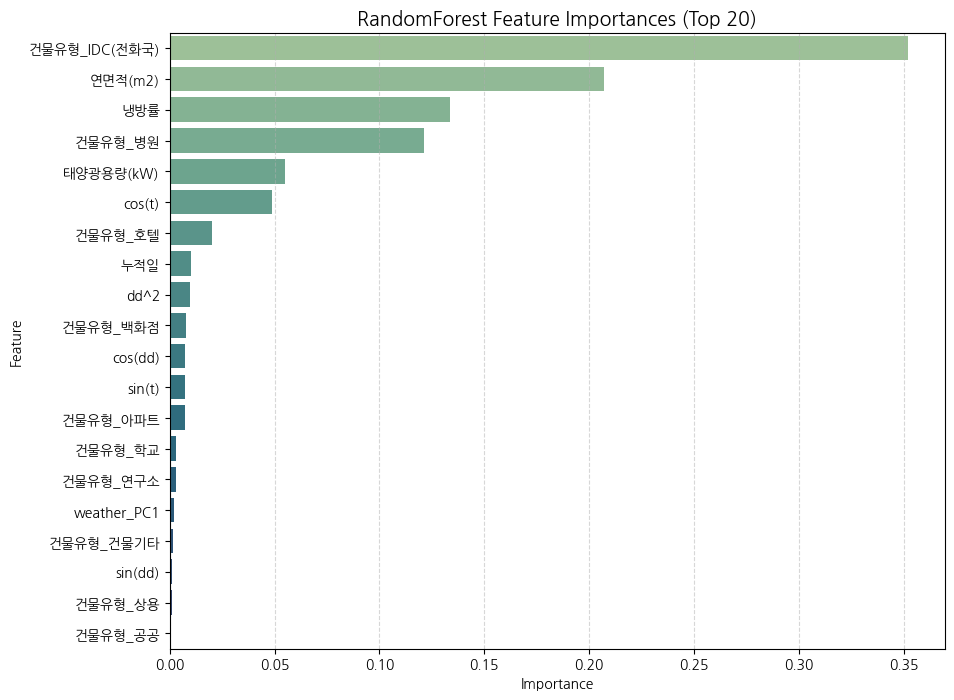

In [7]:
# 1. 변수 이름: X는 DataFrame 상태이므로 여기서 가져오기
features = X.columns

# 2. 특성 중요도 추출
importances = model_rf.feature_importances_  # model = 학습된 RandomForestRegressor

# 3. DataFrame 구성
feat_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# 4. 중요도 상위 20개 정렬
top_feat_df = feat_df.sort_values(by='Importance', ascending=False).head(20)

# 5. 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_feat_df, palette='crest')
plt.title('RandomForest Feature Importances (Top 20)', fontsize=14)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# 시각화: 선형 회귀 계수

C:\Users\user\AppData\Local\Temp\ipykernel_2056\767041416.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coeff_df, palette='crest')


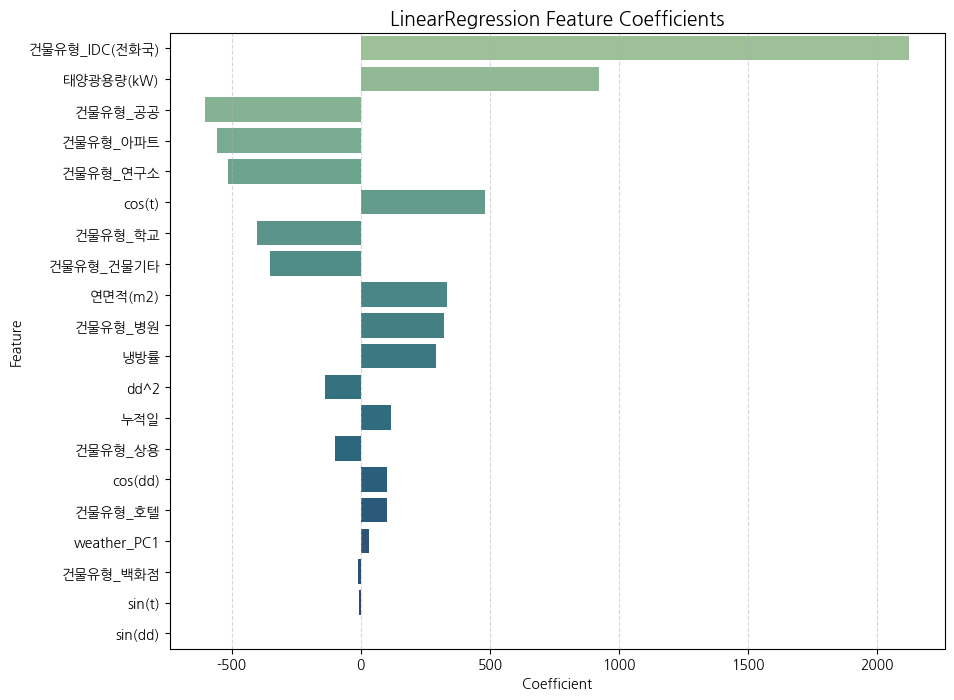

          Feature  Coefficient
3   건물유형_IDC(전화국)  2125.793454
1       태양광용량(kW)   922.901129
5         건물유형_공공  -603.733592
9        건물유형_아파트  -556.198405
10       건물유형_연구소  -514.020507
17         cos(t)   482.003757
11        건물유형_학교  -402.404477
4       건물유형_건물기타  -352.373243
0         연면적(m2)   332.775796
7         건물유형_병원   322.173339
2             냉방률   292.707312
14           dd^2  -138.581942
13            누적일   116.895707
8         건물유형_상용  -101.010592
15        cos(dd)   100.791209
12        건물유형_호텔   100.741391
19    weather_PC1    30.474310
6        건물유형_백화점   -11.120900
18         sin(t)    -7.909469
16        sin(dd)    -0.292958


In [8]:
# 2. 선형 회귀 계수
coeff_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model_lr.coef_.ravel()
}).sort_values(by='Coefficient', key=abs, ascending=False)

# 3. 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coeff_df, palette='crest')
plt.title('LinearRegression Feature Coefficients', fontsize=14)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

print(coeff_df)